

##  필수과제 1-1


- feature 추가해서 성능 올리기


In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore', category=Warning)

# 캘리포니아 주택 데이터셋 로드
california = fetch_california_housing()
X, y = pd.DataFrame(california.data, columns=california.feature_names), california.target

<Axes: >

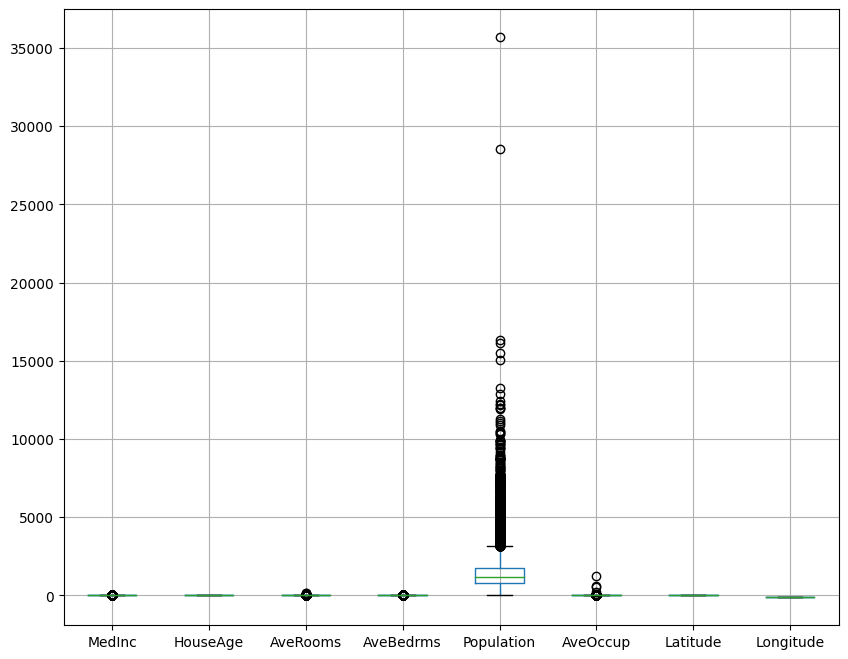

In [2]:
# boxplot으로 이상치 탐지

plt.figure(figsize=(10, 8))
X.boxplot()

In [3]:
# boxplot 상에서 이상치가 있는 열들만 선택
X_sp = X.loc[:, ~X.columns.isin(['HouseAge', 'Latitude', 'Longitude'])]

### 회귀분석 진행

In [4]:
# train, test 분리
X_df = X_sp.values
X_train, X_test, y_train, y_test = train_test_split(X_df, y, train_size=0.7, test_size=0.3, random_state=0)

# 단순 선형회귀 학습
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)

# 예측값을 베이스로 변화 확인
y_pred1 = lr.predict(X_test)
mse1 = mean_squared_error(y_test, y_pred1)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr.score(X_train, y_train)))
print(f'MSE:{mse1}')

R-square:0.52413
MSE:0.6987747350724564


In [5]:
# OLS로 평가
X_const = sm.add_constant(X_sp) # 상수항 추가
ml1 = sm.OLS(y, X_const).fit()
ml1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.511
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     4321.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:46:35   Log-Likelihood:                -24849.
No. Observations:               20640   AIC:                         4.971e+04
Df Residuals:                   20634   BIC:                         4.976e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1754      0.022      7.918      0.000       0.132       0.219
MedInc         0.5370      0.004    126.383      0.000       0.529       0.545
AveRooms      -0.2394      0.006    -38.991      0.000      -0.251      -0.227
AveBedrms      1.0729      0.030     35.389      0.000       1.014       1.132
Population -3.483e-05   4.99e-06     -6.985      0.000   -4.46e-05   -2.51e-05
AveOccup      -0.0042      0.001     -7.728      0.000      -0.005      -0.003
==============================================================================
Omnibus:                     4897.307   Durbin-Watson:                   0.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18754.391
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                       7.070   Cond. No.                     1.13e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.13e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 이상치 확인 및 전처리


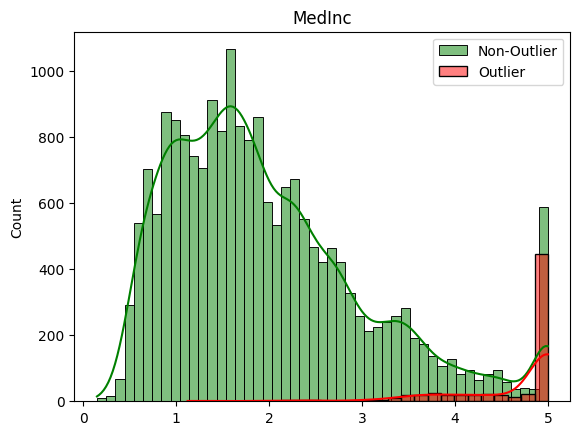

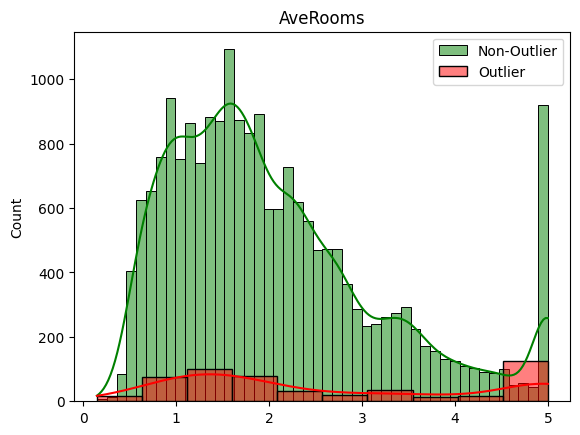

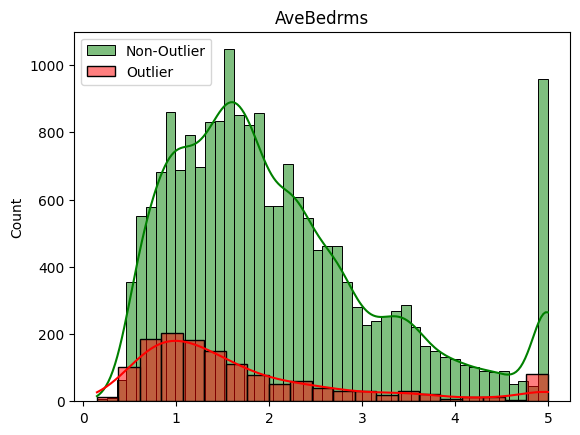

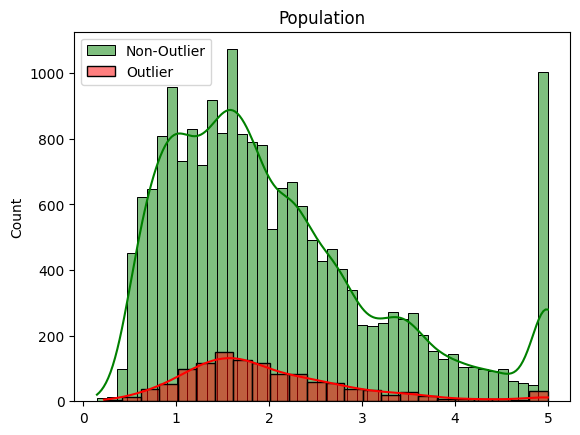

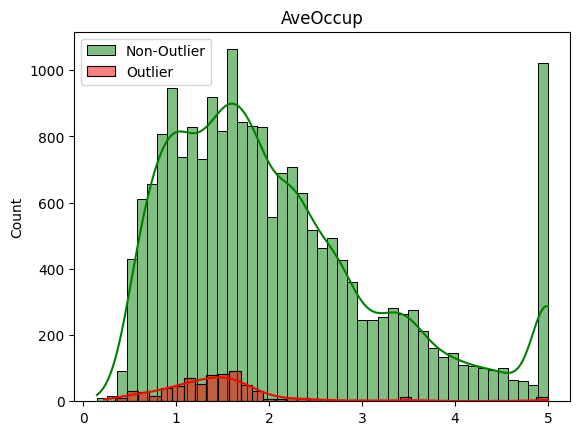

In [6]:
# IQR 생성
for feature in X_sp.columns :
  Q1 = X_sp[feature].quantile(0.25)
  Q3 = X_sp[feature].quantile(0.75)
  IQR = Q3 - Q1

  # 이상치 여부 컬럼
  X_sp[f'{feature}_Outlier'] = ((X_sp[feature] < (Q1 - IQR*1.5)) | (X_sp[feature] > (Q3 + IQR*1.5)))

  # 이상치 여부에 따른 집값 데이터 확인
  non_outlier_prices = {}
  outlier_prices = {}

  non_outlier_prices[feature] = y[X_sp[f'{feature}_Outlier'] == False]
  outlier_prices[feature] = y[X_sp[f'{feature}_Outlier'] == True]

  # 이상치 비교 시각화
  sns.histplot(non_outlier_prices[feature], color='green', kde=True, label='Non-Outlier')
  sns.histplot(outlier_prices[feature], color='red', kde=True, label='Outlier')
  plt.title(f'{feature}')
  plt.legend()
  plt.show()

In [7]:
df = X_sp[['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup']]

# 이상치 개수 확인
for i in df.columns :
  print(f'{i}_Outlier_Count:', len(y[X_sp[f'{i}_Outlier']]))

MedInc_Outlier_Count: 681
AveRooms_Outlier_Count: 511
AveBedrms_Outlier_Count: 1424
Population_Outlier_Count: 1196
AveOccup_Outlier_Count: 711


* 통계적으로 이상치 여부에 따른 집값 평균의 차이가 유의미한가 ?

In [8]:
from scipy import stats

# 이상치 여부에 따른 집값 데이터
for i in df.columns :
  t_stat, p_value = stats.ttest_ind(y[X_sp[f'{i}_Outlier']==False], y[X_sp[f'{i}_Outlier']==True] , equal_var=False)

  print(f'T-static : {t_stat}')
  print(f'P-value : {p_value}')

  # p-value
  if p_value < 0.05 :
    print(f'{i}의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하다.')
  else :
    print(f'{i}의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하지 않다.')

T-static : -96.60151073759215
P-value : 0.0
MedInc의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하다.
T-static : -7.748619132715463
P-value : 4.862718291576454e-14
AveRooms의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하다.
T-static : 10.813523508327332
P-value : 2.294453537965631e-26
AveBedrms의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하다.
T-static : 1.8684616252440343
P-value : 0.06190194576024713
Population의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하지 않다.
T-static : 19.428318381529284
P-value : 1.520869117579521e-69
AveOccup의 이상치 여부에 따른 집값 평균의 차이는 통계적으로 유의미하다.


* 유의수준을 0.05라고 가정했을 때, 통계적으로 유의미하지 않은 'Population' 변수를 제외하고 나머지 변수에 대해 진행



### 회귀분석을 통해 이상치에 대한 파생변수를 만들었을 때 성능비교


In [9]:
# 캘리포니아 주택 데이터셋 로드
california = fetch_california_housing()
X, y = pd.DataFrame(california.data, columns=california.feature_names), california.target

X = X[['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup']]

# IQR 다시 생성
for feature in X.columns :
  Q1 = X[feature].quantile(0.25)
  Q3 = X[feature].quantile(0.75)
  IQR = Q3 - Q1

  # IQR 지수를 0과 1 이진분류로 이상치에 가중치를 부여해서 학습하면 실제 성능이 조금은 올라갈까?
  lower_bound = Q1 - IQR*1.5
  upper_bound = Q3 + IQR*1.5

  # 이상치 파생변수 만들기
  X[f'{feature}_Outlier'] = ((X[feature] < lower_bound) | (X[feature] > upper_bound)).astype(int)

X

,MedInc,AveRooms,AveBedrms,AveOccup,MedInc_Outlier,AveRooms_Outlier,AveBedrms_Outlier,AveOccup_Outlier
0,8.3252,6.984127,1.023810,2.555556,1,0,0,0
1,8.3014,6.238137,0.971880,2.109842,1,0,0,0
2,7.2574,8.288136,1.073446,2.802260,0,0,0,0
3,5.6431,5.817352,1.073059,2.547945,0,0,0,0
4,3.8462,6.281853,1.081081,2.181467,0,0,0,0
...,...,...,...,...,...,...,...,...
20635,1.5603,5.045455,1.133333,2.560606,0,0,0,0
20636,2.5568,6.114035,1.315789,3.122807,0,0,1,0
20637,1.7000,5.205543,1.120092,2.325635,0,0,0,0
20638,1.8672,5.329513,1.171920,2.123209,0,0,0,0


<이상치 전처리 전>

R-square:0.52413

MSE:0.6987747350724564

In [10]:
# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)

# 이상치 피처를 넣은 다중선형회귀 학습
lr1 = LinearRegression(fit_intercept=True)
lr1.fit(X_train, y_train)

# 예측값을 베이스로 변화 확인
y_pred2 = lr1.predict(X_test)
mse2 = mean_squared_error(y_test, y_pred2)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr1.score(X_train, y_train)))
print(f'MSE:{mse2}')

R-square:0.52541
MSE:0.6954392732368418




-> 결정계수는 높아지고, MSE는 낮아져 성능이 좋아졌다고 해석할 수 있다.



In [11]:
# OLS로 평가
X_const1 = sm.add_constant(X) # 상수항 추가
ml2 = sm.OLS(y, X_const1).fit()
ml2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     2726.
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        01:46:46   Log-Likelihood:                -24798.
No. Observations:               20640   AIC:                         4.961e+04
Df Residuals:                   20631   BIC:                         4.969e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0430      0.024      1.812      0.070      -0.003       0.089
MedInc                0.5554      0.005    110.438      0.000       0.546       0.565
AveRooms             -0.2461      0.006    -39.579      0.000      -0.258      -0.234
AveBedrms             1.1400      0.031     36.764      0.000       1.079       1.201
AveOccup             -0.0038      0.001     -6.920      0.000      -0.005      -0.003
MedInc_Outlier       -0.2917      0.040     -7.249      0.000      -0.371      -0.213
AveRooms_Outlier     -0.0823      0.043     -1.899      0.058      -0.167       0.003
AveBedrms_Outlier    -0.0882      0.025     -3.563      0.000      -0.137      -0.040
AveOccup_Outlier     -0.2512      0.031     -8.060      0.000      -0.312      -0.190
==============================================================================
Omnibus:                     4915.295   Durbin-Watson:                   0.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18532.990
Skew:                           1.154   Prob(JB):                         0.00
Kurtosis:                       7.028   Cond. No.                         89.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 필수과제 1-2

- 스케일링을 통해 성능 높이기 (StandardScaler, MinMaxScaler)
- 데이터별로 각각 다른 단위를 가지고 있기 때문에, 피쳐의 단위를 일정하게 맞춰주는 과정이 필요하다 !

In [12]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore', category=Warning)

* Base 성능


In [13]:
# 캘리포니아 주택 데이터셋 로드
california = fetch_california_housing()
X, y = pd.DataFrame(california.data, columns=california.feature_names), california.target

# 데이터셋 재구성
X_sp = X.loc[:, ~X.columns.isin(['HouseAge', 'Population' 'Latitude', 'Longitude'])]

# train, test 분리
X_train, X_test, y_train, y_test = train_test_split(X_sp, y, train_size=0.7, test_size=0.3, random_state=0)

# 선형회귀 학습
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train, y_train)

# 예측값을 베이스로 변화 확인
y_pred = lr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr.score(X_train, y_train)))
print(f'MSE:{mse}')

R-square:0.52637
MSE:0.6919753993502883


In [14]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

# 표준화된 데이터 선형회귀 학습
lr_std = LinearRegression(fit_intercept=True)
lr_std.fit(X_train_std, y_train)

# 예측값을 베이스로 변화 확인
y_pred_std = lr_std.predict(X_test_std)
mse_std = mean_squared_error(y_test, y_pred_std)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr_std.score(X_train_std, y_train)))
print(f'MSE:{mse_std}')

R-square:0.52637
MSE:0.6919753993502926


In [15]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

mms = MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_test_mms = mms.transform(X_test)

# 정규화된 데이터 선형회귀 학습
lr_mms = LinearRegression(fit_intercept=True)
lr_mms.fit(X_train_mms, y_train)

# 예측값을 베이스로 변화 확인
y_pred_mms = lr_mms.predict(X_test_mms)
mse_mms = mean_squared_error(y_test, y_pred_mms)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr_mms.score(X_train_mms, y_train)))
print(f'MSE:{mse_mms}')

R-square:0.52637
MSE:0.6919753993502924


-> 스케일링 전후의 성능을 비교해보면 결정계수와 MSE 모두 거의 비슷한 값을 나타낸다.

 이는 각 피쳐의 단위가 크게 다르지 않고, 선형회귀모형은 단위에 크게 영향을 받지 않기 때문이라고 생각한다.

* 정규분포 변환을 통해 성능 높이기 (Box-Cox는 양수인 경우에만 사용가능, Yeo-Johnson)
* 정규분포 변환은 이상치에 대한 영향을 줄일 수 있으며, 통계적 가정을 충족시키기 위해 도움을 준다.
* 로그 변환은 저번 필수과제에 넣었으므로 한 번 더 언급하지는 않을 예정

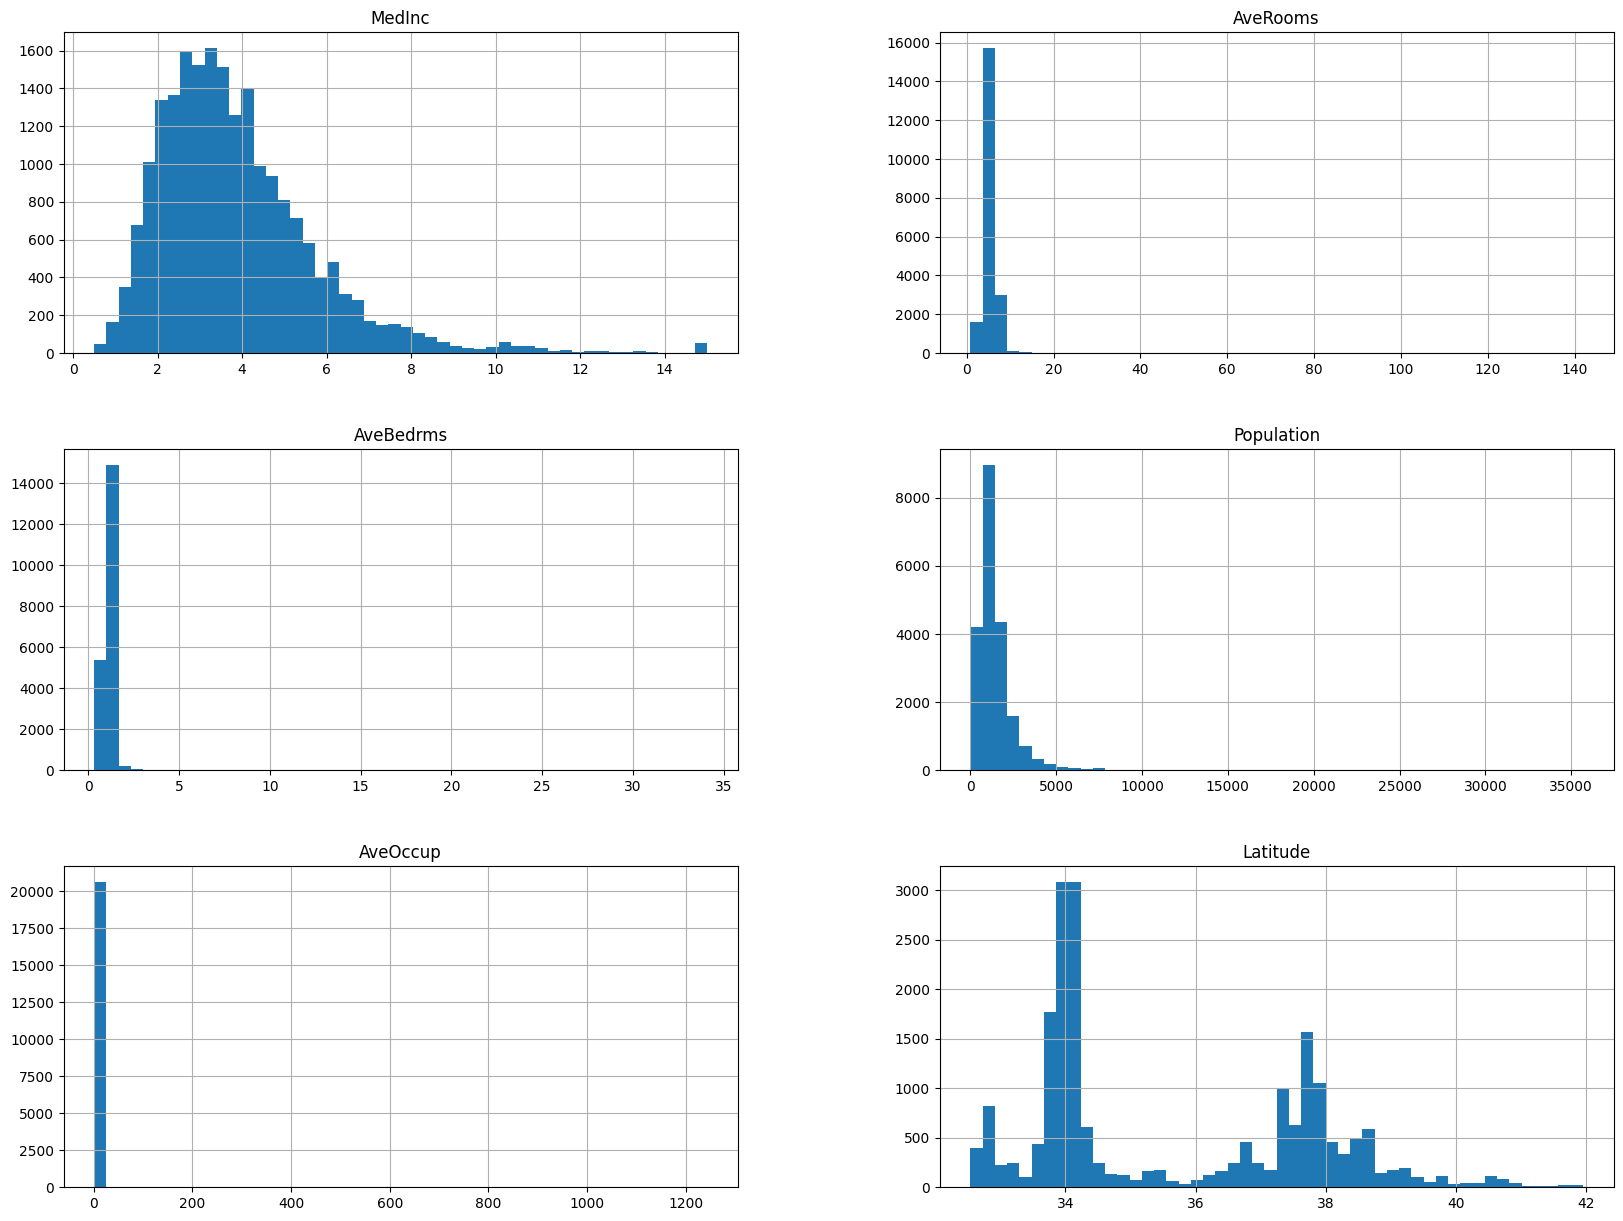

In [16]:
# 데이터 프레임 히스토그램 확인
X_sp.hist(bins=50, figsize=(20,15))
plt.show()

In [17]:
# Box-Cox
from sklearn.preprocessing import PowerTransformer

box = PowerTransformer(method='box-cox')
X_train_box = box.fit_transform(X_train)
X_test_box = box.transform(X_test)

# 박스-콕스 변환된 데이터 선형회귀 학습
lr_box = LinearRegression(fit_intercept=True)
lr_box.fit(X_train_box, y_train)

# 예측값을 베이스로 변화 확인
y_pred_box = lr_box.predict(X_test_box)
mse_box = mean_squared_error(y_test, y_pred_box)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr_box.score(X_train_box, y_train)))
print(f'MSE:{mse_box}')

R-square:0.54272
MSE:0.6208714797682322


In [18]:
# Yeo-Johnson
from sklearn.preprocessing import PowerTransformer

yeo = PowerTransformer(method='yeo-johnson')
X_train_yeo = yeo.fit_transform(X_train)
X_test_yeo = yeo.transform(X_test)

# 박스-콕스 변환된 데이터 선형회귀 학습
lr_yeo = LinearRegression(fit_intercept=True)
lr_yeo.fit(X_train_yeo, y_train)

# 예측값을 베이스로 변화 확인
y_pred_yeo = lr_yeo.predict(X_test_yeo)
mse_yeo = mean_squared_error(y_test, y_pred_yeo)

# 결정계수, MSE 출력
print('R-square:{:.5f}'.format(lr_yeo.score(X_train_yeo, y_train)))
print(f'MSE:{mse_yeo}')

R-square:0.54413
MSE:0.6191143723457991


-> box-cox와 yeo-johnson 모두 결정계수는 높아지고, MSE는 낮아져서 정규분포 변환을 통해 모델의 성능이 좋아졌다고 해석할 수 있다. 최종적으로 yeo-johnson 변환이 해당 데이터셋과 모델에서 성능을 가장 향상시킬 수 있게 만드는 스케일링 기법이다.